# G4LumaCam Tutorial

Tsviki Y. Hirsh, Oct 28th 2025

Welcome to the G4LumaCam tutorial! This notebook will guide you through the complete workflow of simulating and analyzing LumaCam operations.

## Overview

G4LumaCam is designed to simulate the full operation of the LumaCam imaging system. The workflow consists of three main parts:

1. **Simulate** - Runs Geant4 simulation using user-defined configurations in a fully analog simulation. Produces a table of scintillation-produced optical photons and saves results to CSV files.

2. **Lens** - Defines the lens assembly system and traces optical photons through the lens. Writes photons as TPX3 or EMPIR photon files for further analysis.

3. **Analyse** - Requires EMPIR installation. Runs standard EMPIR reconstruction and allows easy exploration of parameter sensitivity.

## Installation

### Prerequisites

It is recommended to install Geant4 through Docker:

```bash
docker pull jeffersonlab/geant4:g4v10.6.2-ubuntu24
```

### Installation Steps

1. Clone the repository:
   ```bash
   git clone https://github.com/TsvikiHirsh/G4LumaCam.git
   ```

2. (Optional) Specify the EMPIR executables path before installation:
   ```bash
   export EMPIR_PATH=/path/to/empir/executables
   ```

3. Navigate to the cloned directory and install:
   ```bash
   cd G4LumaCam
   pip install .
   ```

## Setup

First, let's import the lumacam package and set up our working directory.

In [1]:
# Import the lumacam package
import lumacam

---

# Part 1: Simulate

The Simulate module runs Geant4 simulations to model particle interactions with the scintillator and generate optical photons.

## Creating a Simulation Object

Initialize the Simulate object with a folder archive path where simulation results will be stored.

In [2]:
# Initialize the Simulate object with an archive folder path
sim = lumacam.Simulate("tutorial_archive/neutrons")

## Configuring the Simulation

G4LumaCam can simulate many particle types including neutrons, gammas, ions, and electrons - any particle type supported by Geant4.

You can use the `Config` object to configure simulation parameters or use one of the predefined configurations. Let's explore some of the default configurations.

### Configuration 1: Neutrons with Time-of-Flight (TOF)

This configuration creates a pulsed neutron source with uniform energy distribution. It's useful for simulating fast resonance imaging through the LumaCam.

In [3]:
# Pulsed neutron source with uniform distribution between 1 and 10 MeV
config = lumacam.Config.neutrons_tof(1, 10)
config

Configuration:
  Particle: neutron
  Energy: uniform distribution from 1 to 10 MeV
  (gradient: 0.0, intercept: 1.0)
  Neutron Flux: 10000.0 n/cm²/s
  Pulse Frequency: 200.0 kHz
  Position: (0, 0, -1085) cm
  Direction: (0, 0, 1)
  Shape: Rectangle (60x60 mm)
  Angle: iso (max theta: 0 deg)
  Sample Material: G4_GRAPHITE
  Sample Thickness: 7.5 cm
  Scintillator: EJ200
  Scintillator Thickness: 2 cm
  CSV Batch Size: 10000
  Progress Interval: 100
  Events: 10000
  Output: sim_data.csv

### Key Configurable Parameters

The configuration allows you to control:

- **Particle type**: Change between neutrons, gammas, etc.
- **Energy**: Set particle energies and distributions
- **Beam geometry**: Control beam spot size and shape
- **Sample properties**: Material and thickness
- **Scintillator**: Type (EJ-200 for fast neutrons, GS-20 for thermal/epithermal) and thickness
- **Timing**: Neutron flux, pulse frequency (to explore different deadtime levels)
- **Geometry**: Knife-edge geometries by adjusting scintillator width
- **Distance**: Time-of-flight distance

## Running the Simulation

Once the configuration is set, run the simulation using the `run` command. A progress bar will show the simulation progress.

In [4]:
# Run the simulation with the configured parameters
df = sim.run(config)

Simulating:   0%|          | 0/10000 [00:00<?, ?events/s]

## Other Available Configurations

G4LumaCam provides several predefined configurations for common use cases.

### Configuration 2: Uniform Neutron Irradiation

Continuous beam of neutrons with uniform irradiation, all starting at t=0.

In [5]:
# Uniform continuous neutron beam
config = lumacam.Config.neutrons_uniform()
config

Configuration:
  Particle: neutron
  Energy: 10.0 MeV
  Position: (0, 0, -1059) cm
  Direction: (0, 0, 1)
  Shape: Rectangle (60x60 mm)
  Angle: iso (max theta: 0 deg)
  Sample Material: G4_GRAPHITE
  Sample Thickness: 2 cm
  Scintillator: EJ200
  Scintillator Thickness: 20 cm
  CSV Batch Size: 1000
  Progress Interval: 100
  Events: 100000
  Output: sim_data.csv

### Configuration 3: Pulsed Neutron Source with Configurable Duration

In [6]:
# Pulsed neutron source with configurable pulse duration
config = lumacam.Config.pulsed_neutron_source()
config.tmax = 100  # Set pulse duration to 100 ns
config

Configuration:
  Particle: neutron
  Energy: 10.0 MeV
  Time spread: 0.0 to 100 ns
  Position: (0, 0, -1059) cm
  Direction: (0, 0, 1)
  Shape: Rectangle (60x60 mm)
  Angle: iso (max theta: 0 deg)
  Sample Material: G4_GRAPHITE
  Sample Thickness: 2 cm
  Scintillator: EJ200
  Scintillator Thickness: 20 cm
  CSV Batch Size: 1000
  Progress Interval: 100
  Events: 100000
  Output: sim_data.csv

### Configuration 4: Epithermal Neutron Resonance Experiments

Uses GS-20 scintillator (10mm thick) optimized for thermal and epithermal neutron interactions.

In [7]:
# Epithermal neutron resonance configuration
config = lumacam.Config.uniform_epithermal_neutrons()

### Configuration 5: Point Ion Source (e.g., Gamma Emitters)

For simulating gamma lines from radioactive isotopes.

In [8]:
# Point source of gamma lines from 60Co
config = lumacam.Config.point_ion(ion_z=25, ion_a=60)

## Simulation Output Structure

The simulation produces CSV files with the following folder structure:

```
tutorial_archive/neutrons/
├── SimPhotons/
│   └── sim_data_0.csv
└── macro.mac
```

### CSV File Contents

Each scintillation event in the `SimPhotons` CSV file contains:

```
id, parent_id, neutron_id, pulse_id, pulse_time_ns, x, y, z, dx, dy, dz, 
toa, wavelength, parentName, px, py, pz, parentEnergy, nx, ny, nz, neutronEnergy
```

Where:
- `x, y, z`: Photon origin position
- `dx, dy, dz`: Photon direction
- `toa`: Time of arrival
- `px, py, pz`: Parent particle (recoil) creation position
- `nx, ny, nz`: Original neutron direction
- Additional tracking IDs and energy information

---

# Part 2: Lens System and Ray Tracing

The Lens module handles optical photon propagation through the lens assembly system.

## Creating a Lens Object

Initialize the Lens object with the path to your simulation archive.

In [2]:
# Initialize the Lens object with the simulation archive
lens = lumacam.Lens(archive="tutorial_archive/neutrons")

Loading simulation data:   0%|          | 0/1 [00:00<?, ?it/s]

## Refocusing the Lens System

Use the `refocus` method to control the focusing of the lens system. Here we focus to the center of the scintillator (z = 13.3 cm).

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


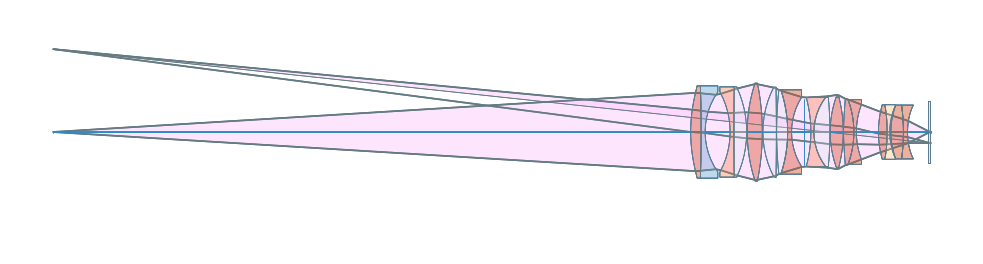

In [3]:
# Focus to the center of the scintillator
opm = lens.refocus(zfine=13.3)

# Visualize the lens system and ray paths
lens.plot(opm)

## Exploring Focusing with Spot Diagrams

Use spot diagrams to explore how well the image focuses onto the detector screen.

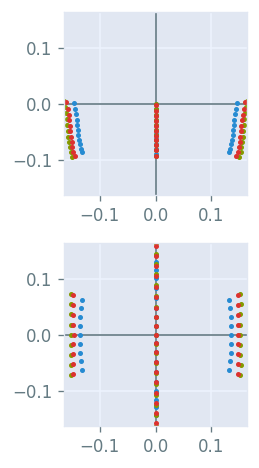

In [4]:
# Generate a spot diagram to visualize focusing
lens.plot(kind="spot")

## Available Lens Assemblies

G4LumaCam currently provides two default lens assemblies:

1. **Nikkor 58mm** (default) - For large field-of-view (FOV) applications
2. **Microscope setup** - A 50mm and variable 80-200mm lenses back-to-back for high magnification applications with small FOV

You can also load any commercial lens from a ZMX file.

### Using the Microscope Setup

Loading simulation data:   0%|          | 0/1 [00:00<?, ?it/s]

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


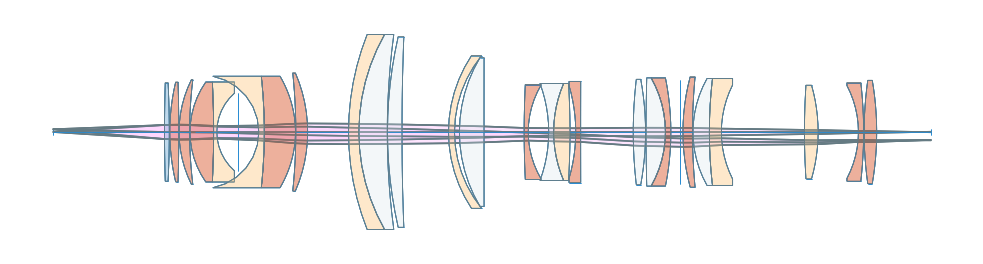

In [5]:
# Initialize with microscope lens assembly
ms_lens = lumacam.Lens(archive="tutorial_archive/neutrons", kind="microscope")

# Visualize the microscope setup
ms_lens.plot()

# For more details, see: notebooks/microscope_setup_tutorial.ipynb

### Loading a Custom Lens from ZMX File

You can load any commercial lens directly from a Zemax (ZMX) file.

Loading simulation data:   0%|          | 0/1 [00:00<?, ?it/s]

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


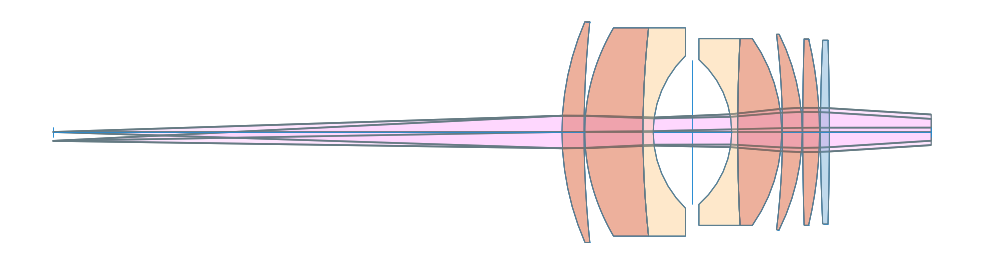

In [6]:
# Load a custom lens from a ZMX file
custom_lens = lumacam.Lens(
    archive="tutorial_archive/neutrons",
    zmx_file="microscope_data/JP1985-040604_Example01P_50mm_1.2f.zmx"
)

custom_lens.plot()

## Ray Tracing Through the Lens

Trace photons through the lens system and save the results.

trace_rays actually does three things:
1. trace rays through the lens system
2. model the saturation of hits on the sensor surface according to the expected image intensifier physical functionality
3. write tpx3 files for further analysis

In [7]:
# Trace rays through the lens system
# The 'blob' parameter controls photon clustering for realistic sensor response
lens.trace_rays(blob=1.0)

Processing 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Tracing rays (sim_data_0.csv):   0%|          | 0/6 [00:00<?, ?it/s]

## Output File Formats

During ray tracing, the traced photons are exported in multiple formats:

- **TPX3 format** - Compatible with Timepix3 detector data format
- **EMPIR photon format** - For use with EMPIR reconstruction software (requires the import_photons binary of EMPIR)

---

# Part 3: Analysis with EMPIR

The Analysis module processes the traced photons using EMPIR reconstruction algorithms.

**Note:** This section requires EMPIR to be installed and accessible.

## Creating an Analysis Object

In [9]:
# Initialize the Analysis object
analyse = lumacam.Analysis("tutorial_archive/neutrons")

## Processing with Default Parameters

The `process()` method runs EMPIR in the background to create EMPIR photon and event files.

In [10]:
# Run EMPIR processing with default parameters
analyse.process()

Processing pixel2photon:   0%|          | 0/6 [00:00<?, ?it/s]

Adding neutron_id:   0%|          | 0/6 [00:00<?, ?it/s]

Processing photon2event:   0%|          | 0/6 [00:00<?, ?it/s]

Exporting photons:   0%|          | 0/6 [00:00<?, ?it/s]

### Output Structure After Processing

After processing, your archive will have the following structure:

```
tutorial_archive/neutrons/
├── ExportedPhotons/
│   ├── exported_traced_data_0_part001.csv
│   ├── exported_traced_data_0_part002.csv
│   └── exported_traced_data_0_part003.csv
├── SimPhotons/
│   ├── macro.mac
│   └── sim_data_0.csv
├── TracedPhotons/
│   └── traced_sim_data_0.csv
├── eventFiles/
│   ├── traced_data_0_part001.empirevent
│   ├── traced_data_0_part002.empirevent
│   └── traced_data_0_part003.empirevent
├── photonFiles/
│   ├── traced_data_0_part001.empirphot
│   ├── traced_data_0_part002.empirphot
│   └── traced_data_0_part003.empirphot
└── tpx3Files/
    ├── traced_data_0_part001.tpx3
    ├── traced_data_0_part002.tpx3
    └── traced_data_0_part003.tpx3
```

## Customizing EMPIR Parameters

You can specify custom EMPIR parameters in several ways:

1. **Pass parameters directly**
2. **Load from a parameter settings JSON file**
3. **Use predefined parameter sets**

### Option 1: Direct Parameter Specification

In [11]:
# Specify parameters directly
analyse.process(dSpace_px=2)

Processing pixel2photon:   0%|          | 0/6 [00:00<?, ?it/s]

Adding neutron_id:   0%|          | 0/6 [00:00<?, ?it/s]

Processing photon2event:   0%|          | 0/6 [00:00<?, ?it/s]

Exporting photons:   0%|          | 0/6 [00:00<?, ?it/s]

### Option 2: Using Parameter Suffixes and Creating Image Stacks

You can provide a suffix name to run analysis in a subfolder and request TIFF stack output.

In [12]:
# Run analysis with custom dSpace parameter, save in subfolder, and create TIFF stack
analyse.process(dSpace_px=3, suffix="dspace_3", event2image=True)

Processing pixel2photon:   0%|          | 0/6 [00:00<?, ?it/s]

Adding neutron_id:   0%|          | 0/6 [00:00<?, ?it/s]

Processing photon2event:   0%|          | 0/6 [00:00<?, ?it/s]

Exporting photons:   0%|          | 0/6 [00:00<?, ?it/s]

### Option 3: Load Parameters from JSON File

In [13]:
# Load parameters from a JSON file
analyse.process(params="tutorial_archive/neutrons/.parameterSettings.json")

Processing pixel2photon:   0%|          | 0/6 [00:00<?, ?it/s]

Adding neutron_id:   0%|          | 0/6 [00:00<?, ?it/s]

Processing photon2event:   0%|          | 0/6 [00:00<?, ?it/s]

Exporting photons:   0%|          | 0/6 [00:00<?, ?it/s]

### Option 4: Use Built-in Parameter Presets

In [14]:
# Use one of the built-in parameter presets
# Available presets can be found in: G4LumaCam/src/lumacam/config/empir_params.py
analyse.process(params="in_focus")

Processing pixel2photon:   0%|          | 0/6 [00:00<?, ?it/s]

Adding neutron_id:   0%|          | 0/6 [00:00<?, ?it/s]

Processing photon2event:   0%|          | 0/6 [00:00<?, ?it/s]

Exporting photons:   0%|          | 0/6 [00:00<?, ?it/s]

---

# Advanced Feature: GroupBy Operations

You can use groupby operations on any column in the SimPhotons data that represents physical measurements. This allows you to analyze data based on specific physical parameters.

## Example: Grouping by Depth (pz)

Here we group by `pz`, the z-depth position where the proton recoil (or other recoil particle) was created, which eventually produced the optical photon that reached the sensor.

In [15]:
# Initialize lens and create groups based on pz (depth)
lens = lumacam.Lens(archive="tutorial_archive/neutrons")

# Group photons by z-depth from 0 to 20 mm in 5 mm steps
lens.groupby("pz", low=0, high=20, step=5)

# Trace rays for each group
lens.trace_rays(blob=1.0)

Loading simulation data:   0%|          | 0/1 [00:00<?, ?it/s]

Creating groups:   0%|          | 0/4 [00:00<?, ?it/s]

Processing groups:   0%|          | 0/4 [00:00<?, ?it/s]

Processing 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Tracing rays (sim_data_0.csv):   0%|          | 0/2 [00:00<?, ?it/s]

Processing 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Tracing rays (sim_data_0.csv):   0%|          | 0/2 [00:00<?, ?it/s]

Processing 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Tracing rays (sim_data_0.csv):   0%|          | 0/2 [00:00<?, ?it/s]

Processing 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

Tracing rays (sim_data_0.csv):   0%|          | 0/2 [00:00<?, ?it/s]

## Analyzing Grouped Data

After creating groups, provide the grouped archive name to the Analysis object. It will automatically recognize the groupby structure.

In [16]:
# Initialize Analysis object with grouped data
# The "/pz" suffix indicates the groupby column
analyse = lumacam.Analysis("tutorial_archive/neutrons/pz")

Detected groupby structure: 4 groups
Groupby column: pz


### Process All Groups

Process all groups with specified parameters. Here we use the "hitmap" preset and request both image stacks and summed images.

In [17]:
# Process all groups with hitmap parameters
# Creates TIFF stacks and summed images for each group
analyse.process("hitmap", event2image=True, sum_image=True)

Processing groups:   0%|          | 0/4 [00:00<?, ?it/s]

### Grouped Archive Structure

After groupby processing, your archive will have the following hierarchical structure:

```
tutorial_archive/neutrons/
├── SimPhotons/
│   └── sim_data_0.csv
├── macro.mac
└── pz/
    ├── 0.000/
    │   ├── ExportedPhotons/
    │   ├── SimPhotons/
    │   ├── TracedPhotons/
    │   ├── eventFiles/
    │   ├── photonFiles/
    │   ├── tpx3Files/
    │   └── final/
    │       ├── image/
    │       └── sum_image/
    ├── 5.000/
    │   └── [same structure as above]
    ├── 10.000/
    │   └── [same structure as above]
    └── 15.000/
        └── [same structure as above]
```

Each group folder contains the complete analysis pipeline results for that depth range.

---

# Summary

This tutorial covered the complete G4LumaCam workflow:

1. **Simulation**: Configure and run Geant4 simulations with various particle types and geometries
2. **Lens System**: Trace optical photons through realistic lens assemblies
3. **Analysis**: Process data with EMPIR reconstruction algorithms
4. **Advanced Analysis**: Use groupby operations to analyze specific physical parameters

## Next Steps

- Explore different particle configurations and energies
- Try custom lens assemblies from ZMX files
- Experiment with different EMPIR parameters
- Use groupby operations to study depth-dependent effects
- Check out the microscope setup tutorial: `notebooks/microscope_setup_tutorial.ipynb`

## Resources

- GitHub Repository: https://github.com/TsvikiHirsh/G4LumaCam
- EMPIR Parameter Configuration: `G4LumaCam/src/lumacam/config/empir_params.py`

Happy simulating! 🎉